<a href="https://colab.research.google.com/github/SandhyaTamilAlagan/Msc-Project/blob/main/imagesuperresolutionsandy25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loading and processing

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def load_high_res_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    # Preprocess high-resolution image as needed (e.g., normalization, etc.)
    imgs = tf.cast(img,dtype = tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return imgs

def create_low_res_image(high_res_image, scale_factor = 2):
    low_res_image = tf.image.convert_image_dtype(high_res_image, tf.uint8) * 255
    low_res_image = tf.image.resize(low_res_image, [64 // scale_factor, 64 // scale_factor], method=tf.image.ResizeMethod.BICUBIC)
    low_res_image = tf.image.convert_image_dtype(low_res_image, tf.float32)
    return low_res_image

def create_train_data_loader(image_folder, batch_size, scale_factor, shuffle=True):
    subfolders = [os.path.join(image_folder, folder) for folder in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, folder))]

    high_res_image_paths = []
    for folder in subfolders:
        high_res_image_paths.extend([os.path.join(folder, file) for file in os.listdir(folder)])

    high_res_image_dataset = tf.data.Dataset.from_tensor_slices(high_res_image_paths)
    high_res_images = high_res_image_dataset.map(load_high_res_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    low_res_image_dataset = high_res_images.map(create_low_res_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return (high_res_images,low_res_image_dataset)

    #dataset = tf.data.Dataset.zip((low_res_image_dataset, high_res_image_dataset))
    #if shuffle:
        #dataset = dataset.shuffle(buffer_size=len(high_res_image_paths), reshuffle_each_iteration=True)

    #dataset = dataset.batch(batch_size)
    #dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    #return dataset



# Data loading and generation
image_folder = '/content/drive/MyDrive/Imageresolution/imagedataset/DIV2K_train_HR'
batch_size = 1
scale_factor = 2  # Change this according to your desired downscaling factor

train_data_loader = create_train_data_loader(image_folder, batch_size, scale_factor)


In [6]:
(hRImages,lRImages) = train_data_loader
hRImagesNp = np.zeros((800,64,64,3),dtype = np.float32)
lRImagesNp = np.zeros((800,32,32,3),dtype = np.float32)

for i,x in enumerate(hRImages):
    hRImagesNp[i,:] = x

for i,x in enumerate(lRImages):
    lRImagesNp[i,:] = x

# Printing out the sample image using Transfer learning for reference

In [8]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the ESRGAN model from TensorFlow Hub
model_url = "https://tfhub.dev/captain-pool/esrgan-tf2/1"  # Example ESRGAN model from TensorFlow Hub
model = hub.load(model_url)

# Preprocess your input image as described in the previous answer
input_image = tf.io.read_file('/content/drive/MyDrive/Imageresolution/imagedataset/DIV2K_train_HR/DIV2K_train_HR/0005.png')
input_image = tf.image.decode_image(input_image, channels=3)
input_image = tf.image.convert_image_dtype(input_image, tf.float32)
input_image = tf.image.resize(input_image, (256, 256))

# Perform super-resolution
sr_image = model(input_image[tf.newaxis, ...])

# Post-process and save the result as described in the previous answer
sr_image = tf.squeeze(sr_image, axis=0)
sr_image = tf.clip_by_value(sr_image, 0.0, 1.0)
sr_image = tf.image.convert_image_dtype(sr_image, tf.uint8)
tf.io.write_file('output_image.jpg', tf.image.encode_jpeg(sr_image))


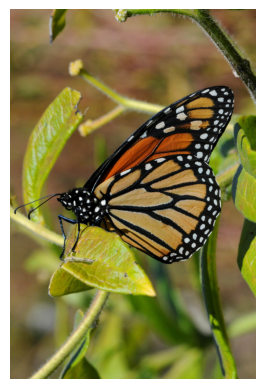

In [9]:
image_path = '/content/drive/MyDrive/Imageresolution/imagedataset/DIV2K_train_HR/DIV2K_train_HR/0006.png'

# Read and decode the image from the file path
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)  # Specify the number of color channels (e.g., 3 for RGB)

# You may want to resize or preprocess the image as needed
# For example, resizing it to a specific size
#image = tf.image.resize(image, [height, width])  # Replace height and width with your desired dimensions

# Convert the image tensor to a NumPy array for displaying
image = image.numpy()

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

# Model building and training

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Discriminator(models.Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Convolutional layers for feature extraction
        self.conv1 = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)
        self.conv2 = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)
        self.conv3 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)
        self.conv4 = layers.Conv2D(512, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)

        # Dense layer for binary classification
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        # Forward pass through convolutional layers
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten the feature maps
        x = self.flatten(x)

        # Perform binary classification
        x = self.dense(x)

        return x


In [11]:
from tensorflow.keras import layers, models, losses, optimizers

upsampling_factor = 4

# Define residual channel attention block (RCAB)
class RCAB(layers.Layer):
    def __init__(self, num_filters):
        super(RCAB, self).__init__()
        self.conv1 = layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(num_filters, kernel_size=3, padding='same')
        self.channel_attention = ChannelAttention(num_filters)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.channel_attention(x)
        return inputs + x

# Define channel attention mechanism
class ChannelAttention(layers.Layer):
    def __init__(self, num_filters):
        super(ChannelAttention, self).__init__()
        self.global_pool = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(num_filters // 16, activation='relu')
        self.dense2 = layers.Dense(num_filters)

    def call(self, inputs):
        # Global Average Pooling
        x = self.global_pool(inputs)
        x = layers.Reshape((1, 1, x.shape[-1]))(x)
        # Dense layers
        x = self.dense1(x)
        x = self.dense2(x)
        # Apply sigmoid activation
        x = tf.nn.sigmoid(x)
        # Apply attention
        return inputs * x


# Generator (Enhancement Network) for ESRGAN
def make_generator_model(scale_factor, num_rcabs = 10, num_filters = 64):
    # Input: Low-resolution image
    inputs = layers.Input(shape=(None, None, 3))

    # Feature extraction layers
    x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

    # Residual blocks
    for _ in range(16):
        residual = x
        x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual])

    # Upscaling layer using sub-pixel convolution (PixelShuffle)
    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale_factor))(x)

    # Output: High-resolution image
    outputs = layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)

    return models.Model(inputs, outputs)

# Discriminator for ESRGAN
def make_discriminator_model():
    inputs = layers.Input(shape=(None, None, 3))

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    x = layers.GlobalAveragePooling2D()(x)  # Flatten the output
    x = layers.Dense(1024, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)


# ESRGAN model combining Generator and Discriminator
def make_esrgan_model(scale_factor):
    # Set the trainable property for Discriminator to False
    discriminator = make_discriminator_model()
    discriminator.trainable = False

    # Input: Low-resolution image
    inputs_lr = layers.Input(shape=(None, None, 3))

    # Generate high-resolution image using Generator
    generated_hr = make_generator_model(scale_factor)(inputs_lr)

    # Discriminator evaluates generated HR images
    validity = discriminator(generated_hr)

    return models.Model(inputs_lr, [generated_hr, validity])

# Create an instance of the ESRGAN model
scale_factor = 2  # Set your desired upscaling factor
esrgan_model = make_esrgan_model(scale_factor)

# Compile the ESRGAN model with appropriate loss and optimizer
criterion_gen = losses.MeanSquaredError()
criterion_disc = losses.BinaryCrossentropy()
optimizer_gen = optimizers.Adam(lr=1e-4)
optimizer_disc = optimizers.Adam(lr=1e-4)

esrgan_model.compile(optimizer=[optimizer_gen, optimizer_disc],
                     loss=[criterion_gen, criterion_disc],
                     loss_weights=[1, 0.01])

# Assuming you have low-resolution and high-resolution image tensors for training
train_low_res_images = lRImagesNp[:600]
train_high_res_images = hRImagesNp[:600]
validation_low_res_images = lRImagesNp[600:800]
validation_high_res_images = hRImagesNp[600:800]


best_gen_loss = float('inf')
best_gen_weights = None

# Lists to store training and validation losses of each epoch
training_losses = []
validation_losses = []

# Create TensorFlow datasets from the tensors
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((train_low_res_images, train_high_res_images)).shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((validation_low_res_images, validation_high_res_images)).shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define the number of training epochs
num_epochs = 100

epoch_training_loss = []
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training
    for batch_low_res, batch_high_res in train_dataset:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate high-resolution images
            generated_hr, validity = esrgan_model(batch_low_res, training=True)
            print("Generated HR and Validity")
            # Calculate Generator loss
            print(batch_high_res.shape)
            print(generated_hr.shape)
            loss_gen = criterion_gen(batch_high_res, generated_hr)
            print("Generator loss ",loss_gen)

            # Calculate Discriminator loss
            loss_disc_real = criterion_disc(tf.ones_like(validity), validity)
            loss_disc_fake = criterion_disc(tf.zeros_like(validity), validity)
            loss_disc = 0.5 * (loss_disc_real + loss_disc_fake)
            print("Discriminator loss ",loss_disc)

        # Backpropagation and optimizer steps
        gradients_gen = gen_tape.gradient(loss_gen, esrgan_model.trainable_variables)
        gradients_disc = disc_tape.gradient(loss_disc, esrgan_model.trainable_variables)
        optimizer_gen.apply_gradients(zip(gradients_gen, esrgan_model.trainable_variables))
        optimizer_disc.apply_gradients(zip(gradients_disc, esrgan_model.trainable_variables))

    epoch_training_loss.append(loss_gen.numpy())
    avg_training_loss = sum(epoch_training_loss) / len(epoch_training_loss)
    training_losses.append(avg_training_loss)

    epoch_validation_loss = []
    for batch_low_res_val, batch_high_res_val in val_dataset:
        # Generate high-resolution images
        generated_hr_val, _ = esrgan_model(batch_low_res_val, training=False)

        # Calculate Generator loss for validation
        loss_gen_val = criterion_gen(batch_high_res_val, generated_hr_val)

        # Append the batch loss to the epoch_validation_loss list
        epoch_validation_loss.append(loss_gen_val.numpy())

    # Calculate average validation loss for the epoch
    avg_validation_loss = sum(epoch_validation_loss) / len(epoch_validation_loss)
    validation_losses.append(avg_validation_loss)

    # Print and save best model based on generator loss
    print(f"Gen Loss: {avg_training_loss:.4f}, Val Loss: {avg_validation_loss:.4f}")

    if avg_training_loss < best_gen_loss:
        best_gen_loss = avg_training_loss
        esrgan_model.layers[1].save_weights('best_esrgan_generator.h5')

print("Training finished.")


Epoch 1/100
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.3352388, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.6931703, shape=(), dtype=float32)


Streaming output truncated to the last 5000 lines.
Discriminator loss  tf.Tensor(0.6931553, shape=(), dtype=float32)
Generated HR and Validity
(8, 64, 64, 3)
(8, 64, 64, 3)
Generator loss  tf.Tensor(0.12891623, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.69315475, shape=(), dtype=float32)
Gen Loss: 0.1246, Val Loss: 0.1392
Epoch 75/100
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.111772634, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.69315386, shape=(), dtype=float32)
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.1093967, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.69315696, shape=(), dtype=float32)
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.11490767, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.69315344, shape=(), dtype=float32)
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0

# Plotting the training and validation loss

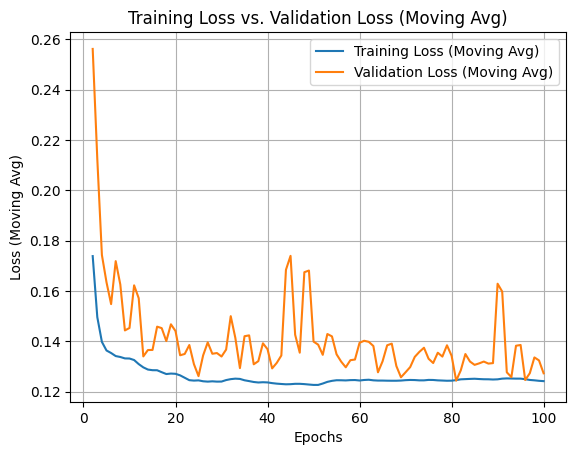

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the training_losses and validation_losses lists from the training process

# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Set the window size for moving average
window_size = 2

# Calculate moving average of training and validation losses
training_losses_moving_avg = moving_average(training_losses, window_size)
validation_losses_moving_avg = moving_average(validation_losses, window_size)

# Create a list of epochs for the x-axis
epochs = list(range(window_size, num_epochs + 1))

# Plot the moving average of training loss vs. validation loss
plt.plot(epochs, training_losses_moving_avg, label='Training Loss (Moving Avg)')
plt.plot(epochs, validation_losses_moving_avg, label='Validation Loss (Moving Avg)')

plt.xlabel('Epochs')
plt.ylabel('Loss (Moving Avg)')
plt.title('Training Loss vs. Validation Loss (Moving Avg)')
plt.legend()
plt.grid(True)
plt.show()


# Saving the best version of the model

In [13]:
esrgan_model.layers[1].save('/content/drive/MyDrive/imageresolution/imagedataset/')
new_model = tf.keras.models.load_model('/content/drive/MyDrive/imageresolution/imagedataset/')
new_model.load_weights('/content/drive/MyDrive/imageresolution/imagedataset/')


**Printing the low resolution image to be tested** **bold text**

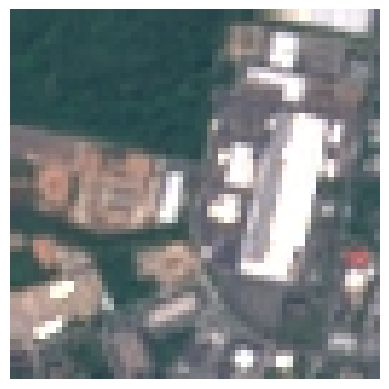

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the file path to your image
image_path = '/content/drive/MyDrive/Imageresolution/esrgan-model/Industrial/Industrial_1.jpg'

# Read and decode the image from the file path
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)  # Specify the number of color channels (e.g., 3 for RGB)

# You may want to resize or preprocess the image as needed
# For example, resizing it to a specific size
#image = tf.image.resize(image, [height, width])  # Replace height and width with your desired dimensions

# Convert the image tensor to a NumPy array for displaying
image = image.numpy()

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

**Printing the high-resolution image from the model loaded**


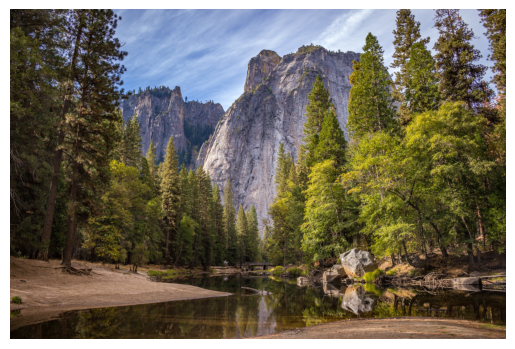

In [19]:
input_image = tf.io.read_file('/content/drive/MyDrive/Imageresolution/esrgan-model/Industrial/Industrial_1.jpg')
input_image = tf.image.decode_image(input_image, channels=3)
input_image = tf.image.convert_image_dtype(input_image, tf.float32)
input_image = tf.image.resize(input_image, (256,256))

# Perform super-resolution
sr_image = model(input_image[tf.newaxis, ...])

# Post-process and save the result as described in the previous answer
sr_image = tf.squeeze(sr_image, axis=0)
sr_image = tf.clip_by_value(sr_image, 0.0, 1.0)
sr_image = tf.image.convert_image_dtype(sr_image, tf.uint8)
tf.io.write_file('output_image.jpg', tf.image.encode_jpeg(sr_image))

image_path = '/content/drive/MyDrive/Imageresolution/imagedataset/DIV2K_train_HR/DIV2K_train_HR/0007.png'

# Read and decode the image from the file path
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)  # Specify the number of color channels (e.g., 3 for RGB)

# You may want to resize or preprocess the image as needed
# For example, resizing it to a specific size
#image = tf.image.resize(image, [height, width])  # Replace height and width with your desired dimensions

# Convert the image tensor to a NumPy array for displaying
image = image.numpy()

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()